<a id='index'></a>
# Deep Q Learning

Vanilla Deep Q Learning with Epsilon-Greedy implementation.

* [Space Invaders](#space-invaders)
    * [DQN](#dqn)
    * [Memory](#memory)
    * [Training](#training)

In [1]:
from typing import Sequence, Tuple
import warnings
from collections import deque

import gym

import numpy as np

from tqdm import tqdm_notebook

from matplotlib import animation
import matplotlib.pyplot as plt

from skimage import transform
from skimage.color import rgb2gray

import tensorflow as tf

from IPython.core.display import display, HTML

In [2]:
warnings.filterwarnings('ignore')

[back to index](#index)

<a id='space-invaders'></a>
## Space Invaders

In [3]:
# env = retro.make(game='SpaceInvaders-Atari2600')
env = gym.make('SpaceInvaders-v0')
one_hot_actions = np.array(np.identity(env.action_space.n, dtype=np.int64))

print('State size: {}\nNo. actions: {}'.format(env.observation_space, env.action_space.n))

State size: Box(210, 160, 3)
No. actions: 6


In [4]:
one_hot_actions

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

In [5]:
def preprocess(frame, resize=(110, 84)):
    '''
        Converts the frame from RGB to 
        grayscale, crops it, normalises 
        the values to 0-1 range, and re-
        sizes to 110 x 84.
    '''
    gray = rgb2gray(frame)
    cropped = gray[8:-12, 4:-12]
    normalised = cropped / 255.0
    return transform.resize(normalised, resize) if resize else normalised

In [6]:
def stack_frames(stack, frame, resize=(110, 84)):
    '''
        Adds a frame to the stack
        and returns a 3D np.array 
        of stacked frames, i.e.
        110 x 84 x 3
    '''
    stack.append(frame)
    return np.stack(stack, axis=2)

In [7]:
def setup_tensorboard(network, path):
    '''
        Launch with: tensorboard --logdir=path
    '''
    writer = tf.summary.FileWriter(path)
    tf.summary.scalar('Loss', network.loss)
    return writer, tf.summary.merge_all() # tensorboard "handle"

In [8]:
def animate_frames(frames, figsize=(10, 15)):
    fig = plt.figure(figsize=figsize)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    return animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)

[back to index](#index)

<a id='dqn'></a>
### DQN - Deep Q Network

A convolutional neural network based DQN model. The input is a stack of frames (one stack is equal to a state) while the output is estimated Q values for each action.

In [9]:
class DQN:
    def __init__(
        self,
        state_size: Tuple[int, int, int],
        n_actions: int,
        alpha: int,
        name: str='DQN'
    ):
        self.reset()
        
        with tf.variable_scope(name):
            '''
                A context manager for defining ops that creates variables (layers).

                This context manager validates that the (optional) values are from t
                he same graph, ensures that graph is the default graph, and pushes a 
                name scope and a variable scope.
                
                See https://www.tensorflow.org/api_docs/python/tf/variable_scope 
            '''
            self.inputs = tf.placeholder(tf.float32, (None, *state_size), name='inputs')
            self.actions = tf.placeholder(tf.float32, (None, n_actions), name='actions')
            
            # Q_target is considered to be "true" Q value but in fact it's estimated with
            # R(s, a) + gamma * max(Q_hat(s', a')) where R is a reward 
            self.Q_target = tf.placeholder(tf.float32, [None], name='Q_target')
            
            self.__conv1 = tf.layers.conv2d(
                inputs=self.inputs,
                activation=tf.nn.elu,
                filters=32,
                kernel_size=(8, 8),
                strides=(4, 4),
                padding='VALID',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                name='conv1'
            )
            
            self.__conv2 = tf.layers.conv2d(
                inputs=self.__conv1,
                activation=tf.nn.elu,
                filters=64, 
                kernel_size=(4, 4),
                strides=(2, 2),
                padding='VALID',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                name='conv2'
            )
            
            self.__conv3 = tf.layers.conv2d(
                inputs=self.__conv2,
                activation=tf.nn.elu,
                filters=64, 
                kernel_size=(3, 3),
                strides=(2, 2),
                padding='VALID',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                name='conv3'
            )
            
            self.__dense1 = tf.layers.dense(
                inputs=tf.layers.flatten(self.__conv3, name='flattened'),
                activation=tf.nn.elu,
                units=512,
                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                name='dense1'
            )
            
            self.__dense2 = tf.layers.dense(
                inputs=self.__dense1,
                activation=None,
                units=n_actions,
                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                name='dense2'
            )
            
            self.output = self.__dense2
            self.Q_hat = tf.reduce_sum(tf.multiply(self.output, self.actions), axis=1) # estimated Q
            self.loss = tf.reduce_mean(tf.square(self.Q_target - self.Q_hat))
            self.optimiser = tf.train.AdamOptimizer(alpha).minimize(self.loss)
            
    def reset(self):
        tf.reset_default_graph()
        
    def predict_action(self, session, state):
        '''
            Predicts the most probable action 
            for a given, single state.
        '''
        Q = session.run(
            self.output, 
            feed_dict={
                self.inputs: state.reshape((1, *state.shape))
            }
        )
        return np.argmax(Q)

[back to index](#index)

<a id='memory'></a>
### Memory

In [10]:
class Memory:
    def __init__(self, size: int, random_state: int=None):
        self.__rng = np.random.RandomState(random_state)
        self.__buffer = deque(maxlen=size)
        
    def add(self, experience: Tuple):
        self.__buffer.append(experience)
        
    def sample(self, batch_size: int):
        assert batch_size < len(self.__buffer)
        sample = rng.choice(np.arange(len(self.__buffer)), size=batch_size, replace=False)
        return [self.__buffer[i] for i in sample]

[back to index](#index)

<a id='training'></a>
### Training

In [11]:
frame_size = (110, 84) # size of the preprocessed game frame
stack_size = 4 # no. frames stacked together
batch_size = 64
n_pre_training_episodes = 128
n_training_episodes = 1000
n_t_periods = 50000
alpha = 1e-3 # learning rate
epsilon_0 = 1 # starting exploration rate
epsilon_min = 1e-2
decay = 1e-3 # exploration decay rate
gamma = 0.9 # rewards discount rate
memory_size = 1000

rng = np.random.RandomState(42)
memory = Memory(memory_size, random_state=42)
state_size = (*frame_size, stack_size)

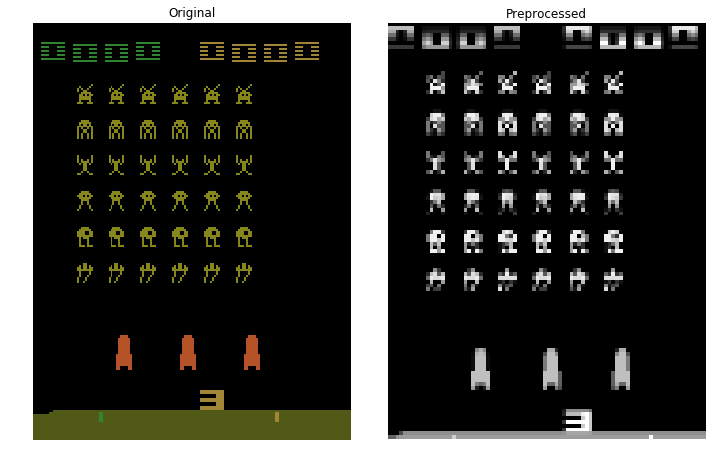

In [12]:
frame = env.reset()

fig, ax = plt.subplots(figsize=(10, 15), ncols=2)

ax[0].imshow(frame)
ax[0].axis('off')
ax[0].set_title('Original')

preprocessed = preprocess(frame, resize=frame_size)
assert preprocessed.shape == frame_size == np.zeros(frame_size).shape

ax[1].imshow(preprocessed, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Preprocessed')

plt.tight_layout()

In [13]:
best_frames = None

dqn = DQN(state_size, env.action_space.n, alpha)
tensorboard_handle, tensorboard_op = setup_tensorboard(dqn, path='tensorboard/dqn/1')
checkpointer = tf.train.Saver()
max_total_reward = float('-inf')
min_loss = float('inf')
rewards = np.zeros(n_training_episodes)
epsilon = epsilon_0
frame = env.reset()
preprocessed = preprocess(frame, resize=frame_size)
stack = deque([preprocessed for _ in range(stack_size)], maxlen=stack_size) 
state = np.stack(stack, axis=2)

assert state.shape == state_size
assert n_pre_training_episodes > batch_size

# "Pre-train" the agent by populating the memory
# with experiences (state, action, reward, state_new, game_over)
# of taking random actions.
with tqdm_notebook(total=n_pre_training_episodes) as pbar:
    pbar.set_description('Pre-training')
    
    for ep in range(n_pre_training_episodes):
        action = rng.randint(0, env.action_space.n)
        frame, reward, game_over, _ = env.step(action)

        if game_over:
            state_new = stack_frames(stack, np.zeros(frame_size))
            memory.add((state, action, reward, state_new, game_over))
            
            # Reset state
            frame = env.reset()
            preprocessed = preprocess(frame, resize=frame_size)
            stack = deque([preprocessed for _ in range(stack_size)], maxlen=stack_size) 
            state = np.stack(stack, axis=2)
        else:
            state_new = stack_frames(stack, preprocess(frame, resize=frame_size))
            memory.add((state, action, reward, state_new, game_over))
            state = state_new            
            
        pbar.update(1)

with tqdm_notebook(total=n_training_episodes) as pbar:
    pbar.set_description('Training')
    
    with tf.Session() as session:       
        session.run(tf.global_variables_initializer())
        
        for ep in range(n_training_episodes):
            # Decay exploration rate
            epsilon = epsilon_0 * np.exp(-decay * ep) if epsilon > epsilon_min else epsilon_min 
            
            # Reset state
            frame = env.reset()
            frames = [frame]
            preprocessed = preprocess(frame, resize=frame_size)
            stack = deque([preprocessed for _ in range(stack_size)], maxlen=stack_size) 
            state = np.stack(stack, axis=2)
            
            total_reward = 0
            
            for t in range(n_t_periods):
                '''
                    Actual Deep Q Learning part.
                '''
                # Learning with experience
                batch = memory.sample(batch_size) # will retrieves batch_size x states
                state_batch = np.array([b[0] for b in batch], ndmin=3) # current
                action_batch = np.array([one_hot_actions[b[1]] for b in batch])
                reward_batch = np.array([b[2] for b in batch])
                state_new_batch = np.array([b[3] for b in batch], ndmin=3) # future
                game_over_batch = np.array([b[4] for b in batch])
                
                # Estimate Q values for the states
                Q_state_new = session.run(
                    dqn.output, 
                    feed_dict={
                        dqn.inputs: state_new_batch
                    }
                )
                
                # Get Q targets
                Q_target = np.zeros((batch_size))
                for i in range(batch_size):
                    Q_target[i] = reward_batch[i] + gamma * np.max(Q_state_new[i]) * (not game_over_batch[i])
                
                loss = session.run(
                    dqn.loss,
                    feed_dict={
                        dqn.inputs: state_batch,
                        dqn.Q_target: Q_target,
                        dqn.actions: action_batch
                    }
                )
                
                if loss < min_loss:
                    min_loss = loss
                
                summary = session.run(
                    tensorboard_op,
                    feed_dict={
                        dqn.inputs: state_batch,
                        dqn.Q_target: Q_target,
                        dqn.actions: action_batch
                    }
                )
                
                # Utils
                tensorboard_handle.add_summary(summary)
                tensorboard_handle.flush()                
                    
                '''
                    Action prediction.
                '''
                if rng.rand() > epsilon:
                    action = rng.randint(0, env.action_space.n)
                else:
                    action = dqn.predict_action(session, state)
                    
                frame, reward, game_over, _ = env.step(action)
                frames.append(frame)
                preprocessed = preprocess(frame, resize=frame_size)
                state_new = stack_frames(stack, preprocessed)
                total_reward += reward
                
                if game_over:
                    # Game over: stack an empty frame
                    state_new = stack_frames(stack, np.zeros(frame_size))
                    memory.add((state, action, reward, state_new, game_over))
                    break
                
                state_new = stack_frames(stack, preprocessed)
                memory.add((state, action, reward, state_new, game_over))
                state = state_new
                
            if total_reward > max_total_reward:
                max_total_reward = total_reward    
                best_frames = frames
                checkpointer.save(session, 'model/model')
                
            rewards[ep] = total_reward
                
            pbar.set_description('Ep: {}, Current: {}, Best: {}'.format(
                ep + 1, total_reward, max_total_reward
            ))        
            
            pbar.update(1)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(rewards)
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')
plt.tight_layout()
plt.show();

In [ ]:
a = animate_frames(best_frames)
a.save('best_training.mpeg', writer='ffmpeg')
HTML(a.to_html5_video())

[back to index](#index)

<a id='test'></a>
### Test

#### Random

In [29]:
n_test_episodes = 100
rewards = np.zeros(n_test_episodes)

for ep in range(n_test_episodes):        
    total_reward = 0
    game_over = False

    while not game_over:
        action = rng.randint(0, env.action_space.n)
        frame_new, reward, game_over, _ = env.step(action)
        total_reward += reward
        
    rewards[ep] = total_reward

print('Min: {}, mean: {}, max: {}'.format(rewards.min(), rewards.mean(), rewards.max()))

Min: 0.0, mean: 0.0, max: 0.0


#### Untrained

In [30]:
n_test_episodes = 100
dqn = DQN(state_size, env.action_space.n, alpha)
rewards = np.zeros(n_test_episodes)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    for ep in range(n_test_episodes):        
        # Resect state
        frame = env.reset()
        preprocessed = preprocess(frame_new, resize=frame_size)
        stack = deque([preprocessed for _ in range(stack_size)], maxlen=stack_size) 
        state = np.stack(stack, axis=2)

        total_reward = 0
        game_over = False

        while not game_over:
            action = dqn.predict_action(session, state)
            frame_new, reward, game_over, _ = env.step(action)
            total_reward += reward
            state_new = stack_frames(stack, preprocess(frame_new, resize=frame_size))
            state = state_new      
        
        rewards[ep] = total_reward

print('Min: {}, mean: {}, max: {}'.format(rewards.min(), rewards.mean(), rewards.max()))

Min: 5.0, mean: 121.65, max: 595.0


#### Trained

In [25]:
n_test_episodes = 100
best_frames = None
max_total_reward = float('-inf')
dqn = DQN(state_size, env.action_space.n, alpha)
rewards = np.zeros(n_test_episodes)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    tf.train.import_meta_graph('model/model.meta').restore(session, 'model/model')
    
    for ep in range(n_test_episodes):        
        # Resect state
        frame = env.reset()
        frames = [frame]
        preprocessed = preprocess(frame_new, resize=frame_size)
        stack = deque([preprocessed for _ in range(stack_size)], maxlen=stack_size) 
        state = np.stack(stack, axis=2)

        total_reward = 0
        game_over = False

        while not game_over:
            action = dqn.predict_action(session, state)
            frame_new, reward, game_over, _ = env.step(action)
            frames.append(frame_new)
            total_reward += reward
            state_new = stack_frames(stack, preprocess(frame_new, resize=frame_size))
            state = state_new      
        
        rewards[ep] = total_reward
        
        if total_reward > max_total_reward:
            max_total_reward = total_reward
            best_frames = frames

print('Min: {}, mean: {}, max: {}'.format(rewards.min(), rewards.mean(), rewards.max()))

INFO:tensorflow:Restoring parameters from model/model
Min: 35.0, mean: 247.25, max: 710.0


In [ ]:
a = animate_frames(best_frames)
HTML(a.to_html5_video())

In [27]:
a.save('best_test.mpeg', writer='ffmpeg')